In [21]:
# Import key libraries
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
import torch.random
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.io import read_image

from PIL import Image

import shutil
import subprocess
from pathlib import Path
import os
import sys
from google.colab import drive
import requests
import zipfile
from timeit import default_timer as timer
import time
import random

from tqdm.auto import tqdm

from typing import List, Tuple, Dict, Optional, Union

import numpy as np

import matplotlib.pyplot as plt

import importlib

try:
  from torchinfo import summary
except:
  subprocess.run(["pip", "install", "torchinfo"],check=True)
  from torchinfo import summary

helper_function_path = "/content/Helper Functions"
if os.path.exists(helper_function_path):
  shutil.rmtree(helper_function_path)

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Helper%20Functions/copy_helper_functions.py"
code = requests.get(URL, timeout=30).text
exec(compile(code, URL, "exec"), {"__name__": "__main__"})

if os.path.exists("/content/Helper Functions"):
  for dirpath, dirnames, filenames in os.walk("/content/Helper Functions", topdown=True):
    sys.path.append(dirpath)
else:
  print("\u274c Error in loading Helper functions ")

import data_setup, engine, model_builder, utils, predict, icons

from helpers import download_data, set_seeds, plot_loss_curves

from copy_git_folder import copy_git_folder

from icons import SUCCESS, ERROR, WARNING, INFO

device = "cuda" if torch.cuda.is_available() else "cpu"



Copying folder to working directory ...
Cleaning up cloned repository ...
✅ Copy complete!


# Downlaod the models from Git

In [22]:
model_path = copy_git_folder("models", "/content/models")

🚀 Initializing sparse clone...
⚠️ /content/models already exists, removing it...
📂 Copying folder to working directory...
🧹 Cleaning up temporary repo...
✅ Copy complete!


# Download 20% sample of Food-101 from GitHub

In [24]:
import urllib.request

URL = "https://github.com/anirguha/Python-2/raw/refs/heads/master/Machine%20Learning%20Datasets/data/pizza_steak_sushi_20_percent.zip"

local_filename = "pizza_steak_sushi_20_percent.zip"

try:
  urllib.request.urlretrieve(URL, local_filename)
  print(f"{SUCCESS} Data downloaded successfully")
except urllib.error.URLError as e:
  print(f"{ERROR} Error in downloading data {e}")

✅ Data downloaded successfully


In [25]:
data_path = Path("/content/data")
img_path = data_path / "pizza_steak_sushi_20_percent"

if not os.path.exists(img_path):
  shutil.unpack_archive(local_filename, img_path, "zip")
  print(f"{SUCCESS} Data unpacked successfully")
else:
  print(f"{INFO} Data already exists at {img_path}")

if local_filename.endswith(".zip"):
  os.remove(local_filename)
  print(f"{SUCCESS} Downloaded zip file removed successfully")

ℹ️ Data already exists at /content/data/pizza_steak_sushi_20_percent
✅ Downloaded zip file removed successfully


# Function to load a model

In [40]:
from typing import Union, Literal
from pathlib import Path

import torch
from torch import nn
from PIL import Image
from torchvision.models import efficientnet_b2, vit_b_16


def load_model(
    model_path: Union[str, Path],
    model_name: Literal["efficientnet_b2", "vit_b_16"],
    device: torch.device = device
) -> nn.Module:
    """
    Load a pre-trained classifier model (EfficientNet-B2 or ViT-B/16)
    with saved weights from disk.

    Args:
        model_name: "efficientnet_b2" or "vit_b_16"
        device:     torch.device to move the model to
        image:      Optional; unused here, but kept for future logic.

    Returns:
        model: nn.Module with loaded weights, set to eval() mode.
    """
    class_names = ["pizza", "steak", "sushi"]
    num_classes = len(class_names)

    if isinstance(model_path, str):
        model_path = Path(model_path)

    # Instantiate model architecture
    if model_name == "efficientnet_b2":

      model_fullpath = model_path / "efficientnetb2_model.pth"

      if not model_fullpath.exists():
        raise FileNotFoundError(f"{model_fullpath} does not exist.")

      model = efficientnet_b2(weights=None, num_classes=num_classes)

    elif model_name == "vit_b_16":
      model_fullpath = model_path / "ViT_b16.pth"

      if not model_path.exists():
        raise FileNotFoundError(f"{model_fullpath} does not exist.")

      model = vit_b_16(weights=None, image_size=384)

      in_features = model.heads.head.in_features
      model.heads.head = nn.Linear(in_features=in_features,
                                    out_features=num_classes)
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")

    # Move to device before loading (map_location also handles CPU/GPU)
    model.to(device)

    # Load state dict
    state_dict = torch.load(model_fullpath, map_location=device)

    # Often better to use strict=False to allow head replacement
    incompatible = model.load_state_dict(state_dict, strict=False)

    if incompatible.missing_keys or incompatible.unexpected_keys:
        print("⚠️ Incompatible keys when loading state_dict:")
        print(f"  Missing keys   : {incompatible.missing_keys}")
        print(f"  Unexpected keys: {incompatible.unexpected_keys}")

    return model

# Function to predict the class of an image

In [60]:
from torchvision.models import ViT_B_16_Weights, EfficientNet_B2_Weights

def pred_class(image: Union[str, Image.Image, torch.Tensor],
               model_path: Union[str, Path],
               model_name: Literal["efficientnet_b2", "vit_b_16"],
               class_names: List[str])-> Tuple[str, float]:

                if isinstance(image, str):
                  image = read_image(image)

                # transform the image based on the model
                if model_name == "efficientnet_b2":
                  image_transforms = EfficientNet_B2_Weights.IMAGENET1K_V1.transforms()
                elif model_name == "vit_b_16":
                  image_transforms = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1.transforms()
                else:
                  raise ValueError(f"Unsupported model name: {model_name}")

                # Tranform the image based on the model
                image = image_transforms(image)

                model = load_model(model_path=model_path, model_name=model_name, device=device)

                model.eval()
                with torch.inference_mode():
                  image = image.unsqueeze(dim=0)
                  image = image.to(device)
                  pred_logits = model(image)
                  pred_probs = torch.softmax(pred_logits, dim=1)
                  pred_label = torch.argmax(pred_probs, dim=1)
                  pred_class = class_names[pred_label]

                return pred_class, pred_probs, model

In [48]:
# download an image from WikiMedia
from download_image import download_image

class_names = ["pizza", "steak", "sushi"]

image_to_download = random.choice(class_names)
print(f"Downloading image of {image_to_download}")

out_dir = "/content/images"

test_image_path = download_image(image_to_download, out_dir=out_dir)

ℹ️  Attempting: Wikimedia Commons -> https://upload.wikimedia.org/wikipedia/commons/3/3c/Pizza_%2847955837793%29.jpg
✅  Saved: /content/images/pizza.jpg (source: Wikimedia Commons; attempts: 1)


In [61]:
img_dir = Path("/content/images")
img_path = list(img_dir.glob("*.jpg"))

img_class = img_path[0].stem

img = Image.open(img_path[0])

model_path = "/content/models"
model = "efficientnet_b2"

class_names = ["pizza", "steak", "sushi"]

predicted_class, pred_probs, model = pred_class(image=img,
                                                model_path=model_path,
                                                model_name=model,
                                                class_names=class_names)

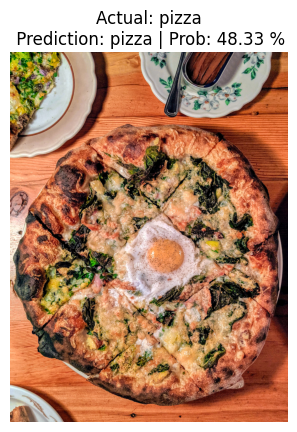

In [62]:
plt.imshow(img)
plt.title(f"Actual: {img_class}\n Prediction: {predicted_class} | Prob: {pred_probs.max()*100:.2f} %")
plt.axis(False);

# Create a demo for EffnertB2 using Gradio

In [63]:
# Move the effnetb2 model to CPU for running on various interfactes (web, moble)
model.to("cpu")

next(iter(model.parameters())).device


device(type='cpu')

# Create a function to pass to the Gradio InterFace

In [64]:
from typing import Tuple, Dict
from time import time

transform_image = EfficientNet_B2_Weights.IMAGENET1K_V1.transforms()

def predict(img: Image) -> Tuple[Dict, float]:
  img = transform_image(img).unsqueeze(0)

  start_time = time()

  model.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(model(img), dim=1)

  pred_probs = pred_probs.squeeze().tolist()

  pred_labels = {class_names[i]: float(round(pred_probs[i],2)) for i in range(len(class_names))}

  pred_time = round((time() - start_time),3)

  return pred_labels, pred_time

In [65]:
# Test the function from one of the images from test dataset
image_test_path = Path("/content/data/pizza_steak_sushi_20_percent/test").glob("*/*.jpg")
image_selected = random.choice(list(image_test_path))
image_selected_class = image_selected.parent.stem

img = read_image(str(image_selected))
pred_labels, pred_time = predict(img=img)

In [66]:
print("Selected Image Class: ", image_selected_class)
print("Preidction labels: ", pred_labels)
print("Prediction time: ", pred_time)

Selected Image Class:  sushi
Preidction labels:  {'pizza': 0.11, 'steak': 0.05, 'sushi': 0.84}
Prediction time:  0.321


In [67]:
# Create example images for input to Gradio

image_test_path = list(Path("/content/data/pizza_steak_sushi_20_percent/test").glob("*/*.jpg"))

example_list = [[str(filepath)] for filepath in random.sample(image_test_path, k=3)]
example_list

[['/content/data/pizza_steak_sushi_20_percent/test/sushi/1404154.jpg'],
 ['/content/data/pizza_steak_sushi_20_percent/test/pizza/2901001.jpg'],
 ['/content/data/pizza_steak_sushi_20_percent/test/steak/1482489.jpg']]

In [68]:
import gradio as gr

title = "FoodVision Mini 🍕, 🥩, 🍣"
description = "An [EfficientNet B2 Feature Extractor](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html)"
article = "Created in Kolkata"

# Create a Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(
                        num_top_classes=3,
                        label="Predictions"),
                    gr.Textbox(label="Prediction time")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6d0b13b0747129cf7c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6d0b13b0747129cf7c.gradio.live
